In [2]:
import torch
from torchvision import utils
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.ion() # interactive mode
%matplotlib inline

### Анализ предобученное сверточной нейронной сети + оптимизация по картинке

In [3]:
#conv_model = models.resnet34(pretrained=True)
pretrained_model = models.alexnet(pretrained=True)

In [4]:
# Параметры данной сети
pretrained_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [5]:
def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    '''
    Визуализировать тензор
    ''' 
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

def savetensor(tensor, filename, ch=0, allkernels=False, nrow=8, padding=2):
    '''
    Сохранить тензор
    '''    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)    
    utils.save_image(tensor, filename, nrow=nrow )

torch.Size([64, 3, 11, 11])


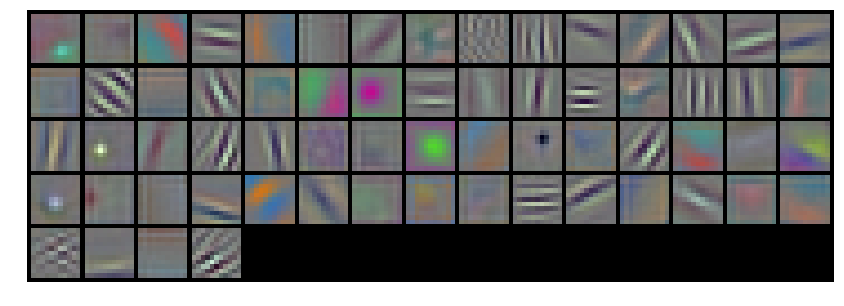

In [6]:
cnn_layer = 0  # выбираем слой 
channel = 3 # выбираем канал

kernel = pretrained_model.features[cnn_layer].weight.data.clone()
print(kernel.shape)

vistensor(kernel, ch=channel, nrow=15, allkernels=False)
savetensor(kernel,'kernel.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

# На графике будут отображены вся ярдра данного слоя, одно ядро - один нейрон, который мы считаем как фильтр 
# в контексте данной задачи. В данном случае размер ядра 3х3, и к сожалению картинки с фильтрами неочевидные.

### Оптимизация по картинке

In [63]:
img_w = nn.Parameter(torch.Tensor(size=[10, 3, 256, 256]))
img_optim = optim.Adam(params=[img_w], lr=1e-2)
target = torch.eye(63)

In [64]:
target.shape

torch.Size([63, 63])

In [65]:
pretrained_model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [66]:
pretrained_model.features[0](img_w).shape

torch.Size([1, 64, 63, 63])

In [69]:
for i in range(3000):
    img_optim.zero_grad()
    img = F.sigmoid(img_w)
    latent = pretrained_model.features[0](img)
    print(latent.shape)
    loss = F.mse_loss(latent.view(63, 63), target)
    loss.backward()
    img_optim.step()
    if i%1000 == 0:
        print(loss.item())

torch.Size([1, 64, 63, 63])


RuntimeError: invalid argument 2: size '[63 x 63]' is invalid for input with 254016 elements at ..\src\TH\THStorage.c:41

In [ ]:
img = F.sigmoid(img_w)
plot_mnist(img.detach().numpy(), (1, 10)) 